<a href="https://colab.research.google.com/github/EZePiZy/deep-learning-course/blob/master/04_Common_CNN_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to common Convolutional Neural Networks Architectures
In this tutorial, we will learn about well-known CNN architectures in the field of computer vision and how to implement them in Keras. Moreover, we will show that some of the standard architectures are already available into the Keras framework. Finally, we will see how we can import and use them in our code.






# CNNs in Image Classification
We start this tutorial by presenting the networks that have been widely used for image classification.  One of the most famous problems among the computer vision community was the annual software contest run by the ImageNet project, **ImageNet Large Scale Visual Recognition Challenge (ILSVRC)**. This contest evaluates how well an algorithm does in the tasks of object category classification and detection. The challenge provides hundreds of object categories and millions of images. The resolution of those images is also bigger than those on MNIST or CIFAR datasets.

As ImageNet is a massive dataset, in the first part of the tutorial we use CIFAR10 dataset, which is directly available on Keras.

As we already have seen, CIFAR10 dataset contains ten different classes of 32x32 images. We will show how to resize the data to be able to use some of the following architectures, as not all of the CNN architectures accepts arbitrary input sizes. Remember that they were designed for ImageNet, and were trained using 224x224 crops.



Let's start by loading CIFAR10:

In [1]:
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical

# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In order to use the original models, we need to resize the CIFAR10 32x32 images into 224x224 images. However, as the whole dataset of CIFAR10 resized ot 224x224 would not fit in our RAM, we need to create a preprocessing step before the first layer. That would take the 32x32 images and, just before going into the architecture, resize them into our desired shape. To do so, we use the `Lambda` layer in Keras, which wraps any expression (in this case `resize_images`) in a layer. We can see how this function looks like for a single batch of 32 images.

1/1 [==============================] - 0s 140ms/step


<ipython-input-2-667486b6bbfd>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train_resized = np.asarray(x_train_resized, dtype = np.int)


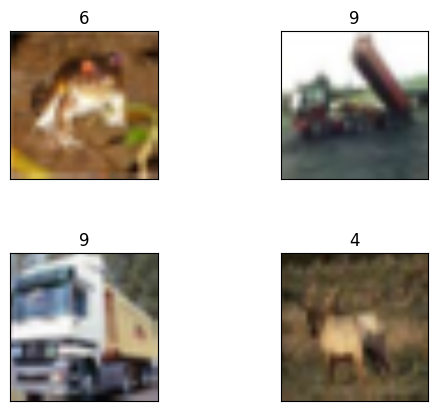


Shape BEFORE Lambda function: (32, 32, 32, 3)
Shape AFTER Lambda function: (32, 224, 224, 3)


In [2]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

from keras.layers import Lambda, Input
from keras.models import Model, Sequential
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


inp = Input(shape=(32, 32, 3))
out = Lambda(lambda image: tf.compat.v1.image.resize_images(image, (224, 224)))(inp)

model = Model(inputs=inp, outputs=out)

x_train_resized = model.predict(x_train[:32, ...])

# Visualization purposes
x_train_resized = np.asarray(x_train_resized, dtype = np.int)

# Let's visualize some examples
N=2
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
items = list(range(0, 100))
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    axes[row,col].imshow(x_train_resized[idx], cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    y_target = int(y_train[idx])
    target = str(items[y_target])
    axes[row,col].set_title(target)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])
plt.show()

print('\nShape BEFORE Lambda function: {}'.format(x_train[:32, ...].shape))
print('Shape AFTER Lambda function: {}'.format(x_train_resized.shape))

Let's now get the dataset ready:

In [3]:
num_classes = 10
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

print('Original training data shape: {}'.format(x_train.shape))
print('Training label shape: {}'.format(y_train.shape))

Original training data shape: (50000, 32, 32, 3)
Training label shape: (50000, 10)


We have the dataset and the Lambda function ready to use to for any of the standard classification architectures. In the next section, we will show how we can code a common architecture and train it with our preprocessed dataset.

## AlexNet

[AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) made a huge impact in 2012 in the ImageNet challenge when it reduced the top-5 error (i.e. the correct class is not among the top-5 predictions) from 26% to 15.3%. The second place was close to 26.2%, and it was not a CNN based system. AlexNet shares a lot in common with its predecessor architecture, [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) network by Yann LeCun et al. When LeNet came out, the computational complexity of the networks was an important constraint. Nowadays, with GPUs being every day more and more powerful, the computational complexity is more plausible to deal with that it was years before. Therefore, the authors in AlexNet decided to make the architecture bigger by using more convolutional layers and more filters.

The architecture proposed in their paper is as follows:

![texto alternativo](https://i.ibb.co/QFG561f/0-x-POQ3bt-Z9r-QO23-LK.png)

The network consisted of convolutional layers with kernels of size 11x11, 5x5 and 3x3. The architecture uses layers with strides, max poolings, dropouts, ReLU activation functions, and three dense layers at the very end. In their original work, the network was split into two streams, as seen in the figure above. That was because GPU constraints, and hence, the authors needed to train it on two separate GPUs. We found a great implementation in [Rizwan's blog](https://engmrk.com/alexnet-implementation-using-keras/), where it presented an AlexNet model without the split concept.

In [4]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()

# Resize input image
model.add(Lambda(lambda x: tf.compat.v1.image.resize_images(x, (224, 224)), input_shape=(32,32,3)))

# 1st Convolutional Layer
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(10))
model.add(Activation('softmax'))

Keep in mind that we can use the original code because we have added a line of code to resize the CIFAR images from 32x32 to 224x224. We can now train our AlexNet model on CIFAR.

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 55s 29ms/step - loss: 2.3038 - accuracy: 0.0991
Epoch 2/3
1563/1563 [==============================] - 45s 29ms/step - loss: 2.3028 - accuracy: 0.0980
Epoch 3/3
1563/1563 [==============================] - 46s 29ms/step - loss: 2.3028 - accuracy: 0.0957


Let's test it:

In [6]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 2.3026 - accuracy: 0.1000
Test loss: 2.302602767944336
Test accuracy: 0.10000000149011612


As it could be observed, training this kind of architectures in big datasets is time-consuming. We might need to train for several hours to start getting state-of-the-art results. That is why Keras saves us time and offers us several pre-trained models on the ImageNet dataset.

Those models can be used directly for image prediction, image classification, feature extraction, or fine-tuning, among others, without the need of spending long hours of training. Isn't that great!?

Even if the task or the dataset is different, using the pre-trained weights as initialisation for the training process provides usually faster convergence (and sometimes better results) than random initialisation.

# Loading Pre-trained Models in Keras

As mentioned, Keras contains many models that have been trained in the ImageNet dataset. Those models were originally released to participate in the ILSVRC competition. However, now they are available alongside their pre-trained weights and used in multiple different tasks. Using pre-trained weights has become a common practice to initialise networks. You can learn more about it [here](https://keras.io/applications/).

We will show how to initialise different models and load their pre-trained weights in ImageNet. Afterwards, we will show how to modify the last layer to classify only the ten classes we have in CIFAR10.

## VGGNet

VGGNet is an architecture presented by Simonyan and Zisserman in 2014. VGGNet is similar to previous AlexNet network, however, it only contains 3x3 convolutional kernels and many more filters. It has become really popular since researchers have found that it can be used to extract powerful feature representations from an image. Therefore, extracted features have proven that they are useful for many other computer vision domains and not only image classification. For instance, they can be used in feature representation, style transfer, or image captioning. You can check the [Oxford VGG paper](https://arxiv.org/pdf/1409.1556.pdf) for further details.

Next image shows the standard VGG architecture ([source](https://www.cs.toronto.edu/~frossard/post/vgg16/)):

![](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

The training time of the architecture is massive since it has more than 130 million parameters. Thankfully, we can find it already pre-trained in Keras. In the original work, authors proposed two versions of VGG; VGG16, and VGG19. Keras provides the two proposed versions, where the difference lies in the number of layers within the network.


In [7]:
from keras.applications.vgg16 import VGG16

model = VGG16(input_shape=(224, 224, 3))

# Optionally, uncomment the following line to display the full model
# model.summary()

553467096/553467096 [==============================] - 20s 0us/step


Now, if we want to load weights from ImageNet we only need to initialise the model as follows:

In [10]:
model = VGG16(weights='imagenet', input_shape=(224, 224, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

The argument `weights` indicates to Keras whether we need to use the pre-trained weights from ImageNet.

If we want to use the original VGG model in CIFAR10 classification, we need to change some things. The first thing to modify is the last fully connected layer. In the original VGG, the last layer is designed to classify among the 1,000 classes provided in ImageNet. In CIFAR10, as we already know, we only have ten classes. Therefore, we switch the last dense layer in the model to be able to perform classification on CIFAR10. Moreover, a common practise when using pre-trained networks is to freeze the model and only train the new dense layer. This strategy is called Transfer Learning. You can read more about it and its difference to Fine-tuning in this great [blog](https://towardsdatascience.com/cnn-transfer-learning-fine-tuning-9f3e7c5806b2). Updating only the weights of the last layer provides several advantages; faster training time, good performance, and sometimes helps the networks to not overfit in small datasets.

In [9]:
from keras.models import Model
from keras.layers import Dense

#Load the VGG
model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False

output = model.get_layer('fc2').output
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

We can confirm that the original dense layer is not there anymore, and instead, we have a new fully-connected layer with only ten activations. Also, as we have frozen the weights of the model, we see that the trainable parameters of the network belong to the new dense layer.

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

As we did before, we add the lambda function to resize the CIFAR10 images before the VGG model. Note that VGG has several dense layers at the end and, therefore, if we would like to use original CIFAR10 image resolutions (32x32), we should modify those dense layers according to the new resolutions.

In [18]:
newInput = Input(batch_shape=(None, 32, 32, 3))
resizedImg = Lambda(lambda image: tf.compat.v1.image.resize_images(image, (224, 224)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

Let's now see how we can modify the VGG architecture to use any input image shape. First of all, if we want to use any other image resolution than 224x224, we need to set the argument `include_top` to `False`. This argument will remove all dense layers at the end of the architecture. Remember that the dense layer comes after a flatten layer (see the model summary above) and, therefore, the size of the flatten vector is fixed. If we modify the input image size, the flatten vector would inevitably change as well. Hence, we need to redefine all dense layers within the model every time we switch the input size.

In [19]:
from keras.layers import Dense, Flatten

# Set include_top to False to avoid loading any dense layer
model = VGG16(include_top=False, input_shape=(32,32,3), weights='imagenet')

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False

# Add the same dense layers as in VGG16
output = model.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

58889256/58889256 [==============================] - 2s 0us/step


We have added the same number of dense layers as in original VGG. We are ready to train the newly added layers as we did in the previous step.

In [20]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
1563/1563 [==============================] - 23s 13ms/step - loss: 1.3532 - categorical_accuracy: 0.5242
Epoch 2/3
1563/1563 [==============================] - 20s 13ms/step - loss: 1.1551 - categorical_accuracy: 0.5930
Epoch 3/3
1563/1563 [==============================] - 20s 13ms/step - loss: 1.0755 - categorical_accuracy: 0.6214


Let's evaluate it:

In [21]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 1.1543 - categorical_accuracy: 0.6010
Test loss: 1.1543141603469849
Test accuracy: 0.6010000109672546


## GoogLeNet / Inception v1

Google presented [GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf) in 2014, the same year that VGGNet was introduced.  GoogLeNet won the ImageNet competition achieving a top-5 error rate of 6.67%, almost betting the human error rate (5%).

GoogLeNet introduced many ideas that helped the development of current state-of-the-art architectures. Instead of stacking more and more CNN layers, GoogLeNet introduced what was called inception modules:

![](https://i.ibb.co/JKqptrj/Googlenet-inception.png)

Those modules apply convolutions with 3 different sizes of kernels (1x1, 3x3 and 5x5) at the same level. The idea behind those modules is based on the premise that significant information can be presented in images at different scales. Therefore, by using a multi-scale approach, they are more likely to capture meaningful information. Moreover, they claimed that designing a wider architecture, instead of a deeper, helps the gradients to navigate throughout the entire network.

![](https://cdn-images-1.medium.com/max/1600/1*uW81y16b-ptBDV8SIT1beQ.png)

The architecture consisted of 9 inception modules stacked linearly, containing 22 deep CNN layers. However, in this network, the total number of parameters was reduced to 4 million! Authors also included two auxiliary classifiers in the middle part of the architecture to avoid the vanishing gradient problem.

You can find a Keras implementation [here](https://gist.github.com/joelouismarino/a2ede9ab3928f999575423b9887abd14).

Even though they won the image classification contest, original Inception v1 was a complex and heavily engineered architecture. Authors introduced many tricks to push its performance, both in terms of speed and accuracy. In the literature, we can find a constant evolution of the architecture which led to the creation of several improved versions. A list and explanation of all inception networks can be found in [this blog](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202).  

In Keras, the Inception model v3 architecture is available, together with its pre-trained weights on ImageNet. It can be initialised as follows:

In [11]:
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(include_top=True, weights='imagenet', classes=1000)

96112376/96112376 [==============================] - 4s 0us/step


Every network has its requirements. For instance, Inception v3 needs a minimum image input size of 75x75 due to its design. We can use the lambda function defined previously in the tutorial and see how the network performs in CIFAR10.

In [12]:
from keras.models import Model
from keras.layers import Lambda, Input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(include_top=False, input_shape=(75, 75, 3), weights='imagenet')

# Resize Input images to 75x75
newInput = Input(batch_shape=(None, 32, 32, 3))
resizedImg = Lambda(lambda image: tf.compat.v1.image.resize_images(image, (75, 75)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False

# Add Dense layer to classify on CIFAR10
output = model.output
output = GlobalAveragePooling2D()(output)
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

model.summary()

87910968/87910968 [==============================] - 4s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_2 (Lambda)           (None, 75, 75, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
Total params: 21823274 (83.25 MB)
Trainable params: 20490 (8

Let's train Inception v3:

In [13]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
1563/1563 [==============================] - 28s 14ms/step - loss: 1.3020 - categorical_accuracy: 0.5573
Epoch 2/3
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1099 - categorical_accuracy: 0.6200
Epoch 3/3
1563/1563 [==============================] - 21s 14ms/step - loss: 1.0675 - categorical_accuracy: 0.6321


And check its accuracy:

In [14]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 5s 13ms/step - loss: 1.1739 - categorical_accuracy: 0.6107
Test loss: 1.1738637685775757
Test accuracy: 0.6107000112533569


## ResNet

In 2015, the winner of the ImageNet challenge was the Residual Neural Network ([ResNet](https://arxiv.org/pdf/1512.03385.pdf)) architecture. Similar to Inception, ResNet is built by micro-architectures modules, called residual blocks. Those blocks introduced skip connections, which allowed to train huge architectures (152 layers) while still having lower complexity than VGGNet. Thus, residual connections allowed authors to design deeper architectures since the gradient could backpropagate easier through the skip connections. Next image is from [Das' blog](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) and shows ResNet architecture with its skip connections:

![texto alternativo](https://cdn-images-1.medium.com/max/800/0*pkrso8DZa0m6IAcJ.png)

Keras offers the implementation of ResNet50 pre-trained on ImageNet. In addition to ResNet50, deeper versions of it, ResNet101 or ResNet152, are widely used nowadays. The main difference lies in the number of layers, e.g., ResNet50 is a 50 layer Residual Network.

In [15]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50

model = ResNet50(include_top=False, input_shape=(32,32,3), weights='imagenet')

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False

# Add Dense layer to classify on CIFAR10
output = model.output
output = GlobalAveragePooling2D()(output)
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

94765736/94765736 [==============================] - 3s 0us/step


Let's check the performance:

In [16]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=32)

score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/3
1563/1563 [==============================] - 20s 10ms/step - loss: 2.0673 - categorical_accuracy: 0.2464
Epoch 2/3
1563/1563 [==============================] - 15s 10ms/step - loss: 1.9169 - categorical_accuracy: 0.3102
Epoch 3/3
313/313 [==============================] - 4s 10ms/step - loss: 1.8133 - categorical_accuracy: 0.3543
Test loss: 1.8133275508880615
Test accuracy: 0.35429999232292175


Note that all previous networks may need a different number of epochs until they converge. Even though we use pre-trained weights, fully training a model can be quite time-consuming.

## Xception, DenseNet, InceptionResNet ...

Keras offers many more network implementations trained on ImageNet. You can check the [documentation](https://keras.io/applications/) to see all of them. Besides, the documentation reports their accuracies, number of parameters and depth of each architecture.

# CNNs for Other Tasks

Besides the success of CNNs in classification problems, CNNs have been used in many other domains. To name a few: image inpainting, facial recognition, semantic segmentation, image captioning, depth prediction, among many others. In this section, we are going to talk about two different problems in computer vision: image denoising and object detection/classification. We are aiming to provide examples of the wide applicability CNNs architectures have.


## Image Denoising with UNet

[UNet](https://arxiv.org/pdf/1505.04597.pdf) was presented in 2015 for biomedical image segmentation, but since then, it has been employed in countless different tasks, such as semantic segmentation, image colorisation, image stylisation... The UNet architectural idea is similar to a regular encoder-decoder layout but with skip connections. The first part of the network encodes the image and reduces it to a map of smaller size, forcing it to capture more global information. Then, the next part is in charge of decoding the image from that reduced feature map.

UNet uses a similar idea of the skip connections used in ResNets. In addition to helping to backpropagate the gradients, the authors used the skip connections to facilitate the flow of information between encoder and decoder. We will talk more about UNet in future tutorials, but for now, let's see how we can code an UNet model:

In [17]:
from keras.layers import Input, UpSampling2D, concatenate
from keras.models import Model

inputs = Input((32,32,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
drop5 = Dropout(0.5)(conv5)

## Now the decoder starts

up6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

up7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

up8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

up9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

model = Model(inputs = inputs, outputs = conv10)

Now, we are going to create a toy example of image denoising.

We have CIFAR10 images already loaded from previous experiments. We add some Gaussian noise (you can play with the scale of the noise) to those CIFAR10 images and then train the UNet to remove that added noise from the images. To do so, we train with the noisy image as input and the clean image as the target. We use the Mean Absolute Error as the loss function to optimise the architecture.

In [18]:
import numpy as np

# Add noise to input images
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.1)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.1)

model.compile(optimizer='Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(x_train_noise, x_train, batch_size=32, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 77s 44ms/step - loss: 0.0660 - mae: 0.0660
Epoch 2/3
1563/1563 [==============================] - 69s 44ms/step - loss: 0.0320 - mae: 0.0320
Epoch 3/3
1563/1563 [==============================] - 68s 44ms/step - loss: 0.0308 - mae: 0.0308


In [19]:
pred = model.predict(x_test_noise)

313/313 [==============================] - 4s 11ms/step


We can visualise the noisy image next to the output of the UNet. The output images are a little bit blurred, but the noise we added has definitely been reduced.

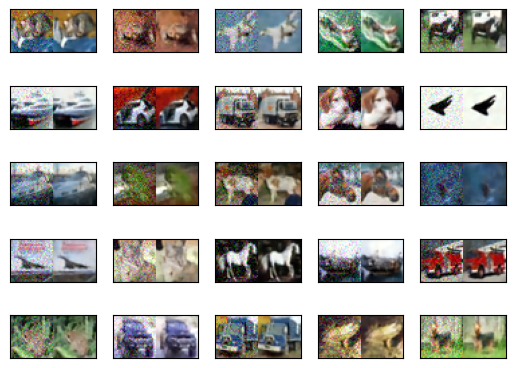

In [20]:
import matplotlib.pyplot as plt

N=5
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col

    im = np.concatenate((np.clip(x_test_noise[idx], 0, 1), np.clip(pred[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])


## Object Detection with RetinaNet

We now will show an object detection example. Object detection differs from image classification in that in an image classification setting we give a label to the whole image, whereas in an object detection setting we give a label and bounding box per each of the classes that are present.

Top detector models include Faster R-CNN, YOLO (yes, it is called YOLO, standing for You Only Look Once; this is the unusual [resume](https://pjreddie.com/static/Redmon%20Resume.pdf) of the YOLO developer) or SSD (Single Shot Detector). Another detector is RetinaNet, which we use to give an example of object detection using the implementation taken from [this repository](https://github.com/fizyr/keras-retinanet). We adapt the example from [this notebook](https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb) in the given repository.

In [21]:
!git clone https://github.com/fizyr/keras-retinanet
%cd ./keras-retinanet
!python setup.py build_ext --inplace
%cd /content/
!pip install keras-resnet
%cd /content/keras-retinanet
!wget https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# We import a bunch of modules
import keras
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# load retinanet model
model_path = './resnet50_coco_best_v2.1.0.h5'
model = models.load_model(model_path, backbone_name='resnet50')
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

%cd /content/

def detection_url(url):
  %cd /content/keras-retinanet
  import requests
  from io import BytesIO
  response = requests.get(url)
  # load image
  image = read_image_bgr(BytesIO(response.content))

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < 0.5:
          break
      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)
      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(15, 15))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()
  %cd /content/

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6224, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6224 (delta 6), reused 9 (delta 2), pack-reused 6205
Receiving objects: 100% (6224/6224), 13.48 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (4207/4207), done.
/content/keras-retinanet
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running build_ext
Compiling keras_retinanet/utils/compute_overlap.pyx because it changed.
[1/1] Cythonizing keras_r

Now, we can use any *URL* pointing to an image (some *URLs* may fail) as input, and we will get an output with the detections out of the 80 classes in Microsoft COCO. If you want to check the classes available, you can print the variable labels_to_names.

As an example, we, of course, input an image full of cats. The labels are a bit blurry, but you can see all of the cats have the correct bounding box around them. However, one of the cats (third bottom row, blue box) was classified as a bear.

/content/keras-retinanet
processing time:  9.603044748306274


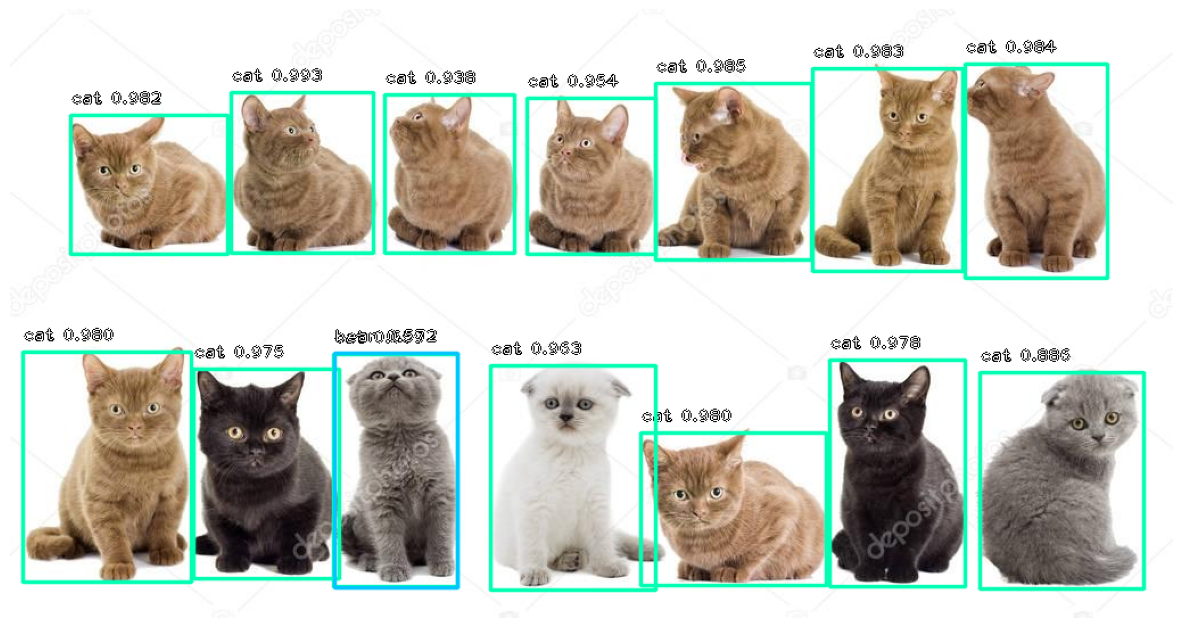

/content


In [22]:
url = 'https://st3.depositphotos.com/1032808/12984/i/950/depositphotos_129842732-stock-photo-group-of-various-breeds-cats.jpg'
detection_url(url)

You can even try with images that contain different classes, and see how RetinaNet deals with multi-class images.

/content/keras-retinanet
processing time:  0.2075490951538086


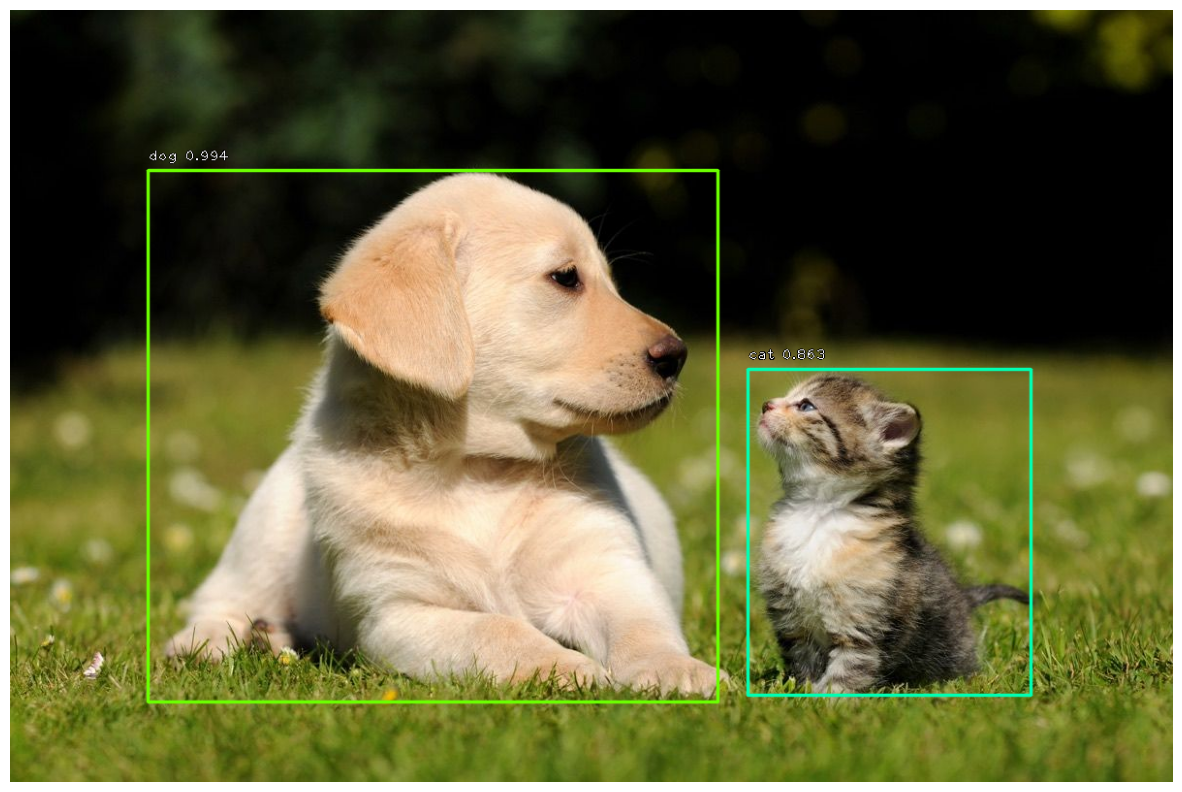

/content


In [24]:
url = 'https://cdn.mos.cms.futurecdn.net/hbKifQWBTcdhTEw8zsJWnF-1200-80.jpg'
detection_url(url)

/content/keras-retinanet
processing time:  4.095308542251587


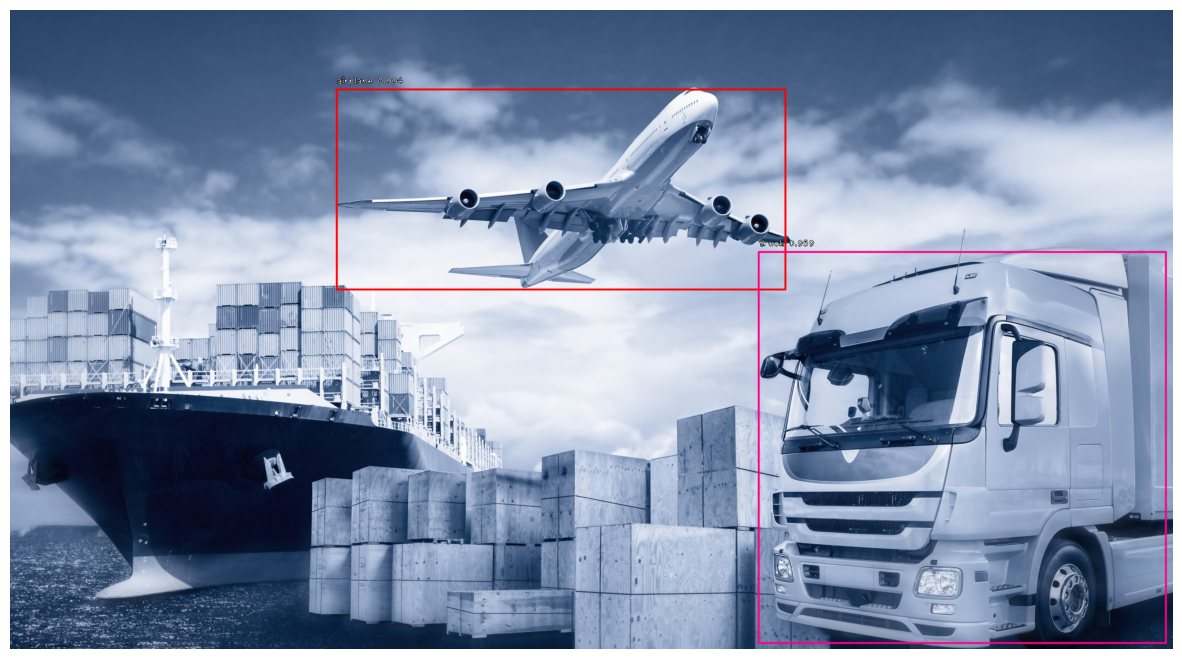

/content


In [26]:
url = "https://www.allthingssupplychain.com/wp-content/uploads/2021/01/GettyImages-1144546289-2048x1126.jpg"
detection_url(url)

# **Coursework**

## Classification on Tiny-ImageNet

In this task, we are going to explore different models to do classification on 64x64 Tiny-ImageNet. Tiny-ImageNet is a smaller version of ImageNet (as the name indicates), containing "only" 200 classes. Each class has 500 images. The test set contains 10,000 images. All images are 64x64 RGB images.

In the Network Training notebook, we explained how to define a validation set, and now we will put that into practice. Hence, as we now have a bigger dataset, we are going to use the standard split of training, validation, and test data. Therefore, you will check the performance of the network in the validation set while training your network. Hence, your decisions need to be based on validation performance. Once you have obtained your best model using the training and validation data, you need to report the performance on the test set. Please try to no overfit to the test data, as in other problems it may not be available to you.

In this exercise, you are asked to train VGG models with different strategies. Optionally, you are asked to use any other architecture of your choice to do classification in Tiny-ImageNet.

Run the following script to get the data.




Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 26.00 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Updating files: 100% (120206/120206), done.
starting loading data
finished loading data, in 12.438083410263062 seconds


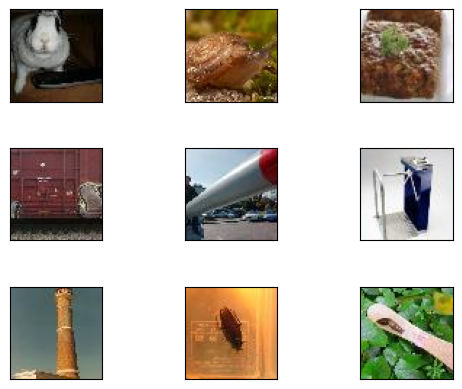

In [27]:
from keras import backend as K
import scipy.ndimage as nd
from keras.models import Sequential,load_model
from keras import regularizers
from keras import initializers
from keras import metrics
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU
from keras import layers
from keras import models
from keras.optimizers import Adam
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt

# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])

    return result

def get_data(id_dict):

    print('starting loading data')
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]

        train_labels_ = np.array([[0]*200]*450)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

        val_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450, 500)]

        val_labels_ = np.array([[0]*200]*50)
        val_labels_[:, value] = 1
        val_labels += val_labels_.tolist()

    for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread('IMagenet/tiny-imagenet-200/val/images/{}'.format(img_name)))

        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))

    return np.array(train_data), np.array(train_labels), np.array(val_data), np.array(val_labels), np.array(test_data), np.array(test_labels)

def shuffle_data(train_data, train_labels, val_data, val_labels):
    # This function shuffles separately the train set and the
    # validation set
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    size = len(val_data)
    val_idx = np.arange(size)
    np.random.shuffle(val_idx)

    return train_data[train_idx], train_labels[train_idx], val_data[val_idx], val_labels[val_idx]

train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

# Let's visualize some examples
N=3
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    tmp = cv2.cvtColor(train_data[idx],cv2.COLOR_BGR2RGB)
    axes[row,col].imshow(tmp, cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data, axis=(0, 1, 2, 3))
train_data = (train_data-mean)/(std+1e-7)
val_data = (val_data-mean)/(std+1e-7)
test_data = (test_data-mean)/(std+1e-7)

**Report**:
*   In a plot, please report the training and validation accuracy curves for the following models:

> *   VGG16 trained from scratch.

> *   Transfer Learning VGG16: load pre-trained ImageNet weights and only train the newly added dense layers.  To do so, freeze all layers and only train the dense layers you have modified in the model.

> *   Fine-tuning VGG16: load pre-trained ImageNet weights and train the whole architecture.

*   Discuss the previous figure in the main text. And report in a table the test accuracy and the training and inference times of previous VGG16 experiments. Training times are computed per epoch and you can find them displayed in the .fit() method information. Report either the total training time, or the number of epochs and training time per epoch. Inference times are computed per image, and we give you the code below to obtain them.

*   Now that we are familiar with loading and using models in Keras, you can use any model of your choice to classify Tiny-ImageNet. You can take the model directly from Keras, any GitHub repository, or do the code yourself. You need to report your results in the previous table and compare your model of choice with previous VGG16 networks.

Note that training/inference time will depend on which GPU you are using. Report the time results in the same instance, or at least when using the same GPU. Report also the GPU you were using to compute those inference times.

In [28]:
from keras.callbacks import EarlyStopping

# model = . . .

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = model.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 200) and (None, 300, 4) are incompatible
